In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pyod.models.copod import COPOD

In [265]:
data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

data_submission = pd.DataFrame({"User_ID" : data_test["User_ID"], "Product_ID" : data_test["Product_ID"]})
data_train.drop(["User_ID", "Product_ID"], axis=1, inplace=True)
data_test.drop(["User_ID", "Product_ID"], axis=1, inplace=True)
data_train.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [266]:
data_train.shape

(550068, 10)

In [267]:
print(f"""Train NaN: 
{data_train.isnull().mean() * 100}

Test NaN: 
{data_test.isnull().mean() * 100}""")

Train NaN: 
Gender                         0.000000
Age                            0.000000
Occupation                     0.000000
City_Category                  0.000000
Stay_In_Current_City_Years     0.000000
Marital_Status                 0.000000
Product_Category_1             0.000000
Product_Category_2            31.566643
Product_Category_3            69.672659
Purchase                       0.000000
dtype: float64

Test NaN: 
Gender                         0.000000
Age                            0.000000
Occupation                     0.000000
City_Category                  0.000000
Stay_In_Current_City_Years     0.000000
Marital_Status                 0.000000
Product_Category_1             0.000000
Product_Category_2            30.969311
Product_Category_3            69.590195
dtype: float64


In [268]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Gender                      550068 non-null  object 
 1   Age                         550068 non-null  object 
 2   Occupation                  550068 non-null  int64  
 3   City_Category               550068 non-null  object 
 4   Stay_In_Current_City_Years  550068 non-null  object 
 5   Marital_Status              550068 non-null  int64  
 6   Product_Category_1          550068 non-null  int64  
 7   Product_Category_2          376430 non-null  float64
 8   Product_Category_3          166821 non-null  float64
 9   Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 42.0+ MB


In [269]:
data_train = data_train.fillna(0.0).astype("object")
data_test = data_test.fillna(0.0).astype("object")
data_train.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,F,0-17,10,A,2,0,3,0.0,0.0,8370
1,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,F,0-17,10,A,2,0,12,0.0,0.0,1422
3,F,0-17,10,A,2,0,12,14.0,0.0,1057
4,M,55+,16,C,4+,0,8,0.0,0.0,7969


In [270]:
y = data_train.pop("Purchase")

In [271]:
def add_enc_cols(df, col_name, arr):
    for i, enc_col in enumerate(arr.T):
        df[f"{col_name}_{i}"] = enc_col
    df = df.drop(col_name, axis=1)
    return df

In [272]:
cat_cols = list(data_train.select_dtypes(include="object"))
oe = OneHotEncoder(sparse=False, drop="first")
for col in cat_cols:
    data_train = add_enc_cols(data_train, col, oe.fit_transform(data_train[col].values.reshape(-1, 1)))
    data_test = add_enc_cols(data_test, col, oe.transform(data_test[col].values.reshape(-1, 1)))
data_train.head()

,Gender_0,Age_0,Age_1,Age_2,Age_3,Age_4,Age_5,Occupation_0,Occupation_1,Occupation_2,...,Product_Category_3_5,Product_Category_3_6,Product_Category_3_7,Product_Category_3_8,Product_Category_3_9,Product_Category_3_10,Product_Category_3_11,Product_Category_3_12,Product_Category_3_13,Product_Category_3_14
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:title={'center':'Marital status distribution'}>

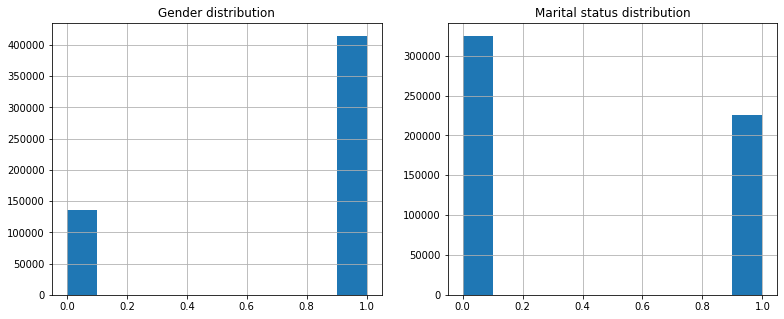

In [273]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
axes[0].set_title("Gender distribution")
data_train.Gender_0.hist(ax=axes[0])
axes[1].set_title("Marital status distribution")
data_train.Marital_Status_0.hist(ax=axes[1])

In [274]:
ss = MinMaxScaler()
data_train = pd.DataFrame(data=ss.fit_transform(data_train), columns=data_train.columns)
data_test = pd.DataFrame(data=ss.transform(data_test), columns=data_test.columns) 

In [388]:
umap_model = umap.UMAP(n_components=2, n_neighbors=35, min_dist=0.175, n_jobs=-1)
data_umap = umap_model.fit_transform(data_train)

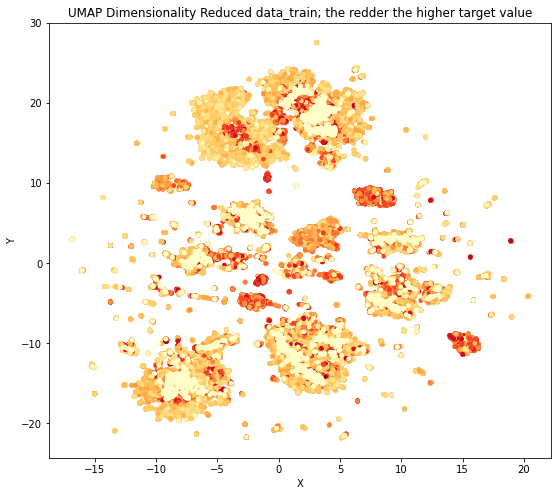

In [389]:
fig, ax = plt.subplots(figsize=(9, 8))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("UMAP Dimensionality Reduced data_train; the redder the higher target value")
ax.scatter(data_umap[:,0], data_umap[:,1], c=y, marker=".", linewidths=1.75, cmap="YlOrRd")

In [325]:
sample = data_train.sample(frac=0.01)
vif_factors = [variance_inflation_factor(sample.values, i) for i in range(sample.shape[1])]

C:\Users\razor\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


<AxesSubplot:title={'center':'Variance Inflation Factor (Multicollinearity)'}, xlabel='Feature'>

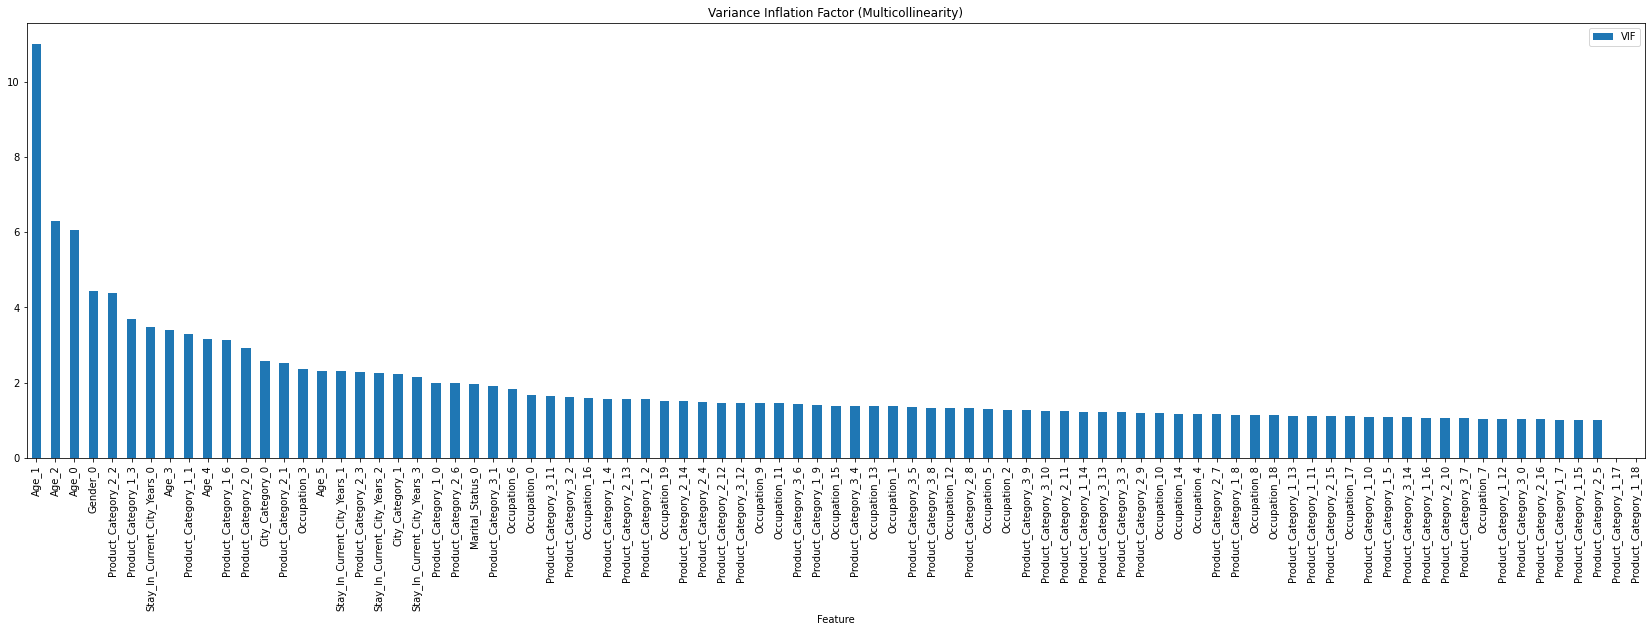

In [328]:
fig, ax = plt.subplots(figsize=(29, 8))
ax.set_title("Variance Inflation Factor (Multicollinearity)")
pd.DataFrame({"Feature" : data_train.columns, "VIF" : vif_factors}).sort_values(by="VIF", ascending=False).plot.bar(x="Feature", y="VIF", ax=ax)

In [ ]:
out_model = COPOD(contamination=0.01, n_jobs=-1)
out_model.fit(data_train)

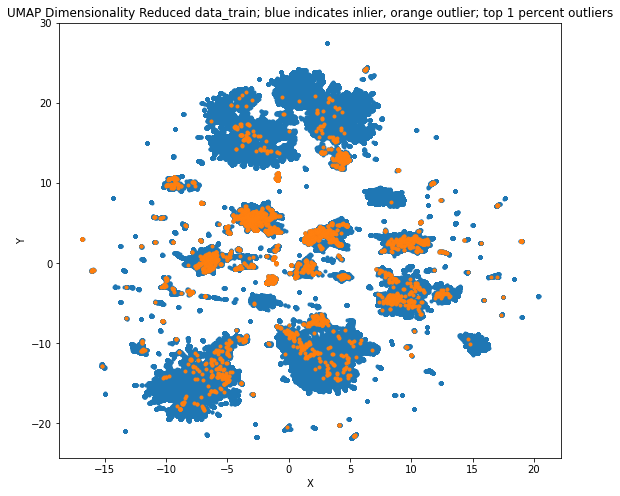

In [425]:
fig, ax = plt.subplots(figsize=(9, 8))
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("UMAP Dimensionality Reduced data_train; blue indicates inlier, orange outlier; top 1 percent outliers")
ax.scatter(data_umap[:,0], data_umap[:,1], marker=".", linewidths=1)
ax.scatter(data_umap[:,0][top_cont], data_umap[:,1][top_cont], marker=".", linewidths=1, cmap="YlOrRd")

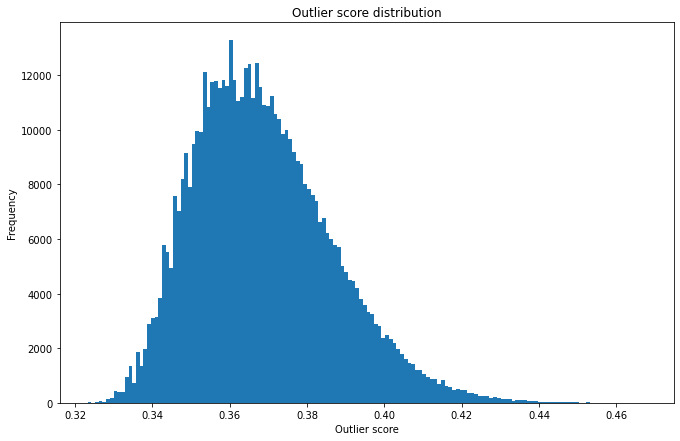

In [458]:
fig, ax = plt.subplots(figsize=(11, 7))
ax.set_xlabel("Outlier score")
ax.set_ylabel("Frequency")
ax.set_title("Outlier score distribution")
_ = ax.hist(out_scores, bins=150)

In [432]:
data_train = data_train.drop(data_train.index[top_cont], axis=0).drop("Age_1", axis=1) # Remove top outliers and age_1 column (high collinearity)
data_test = data_test.drop("Age_1", axis=1)